In [27]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sys
import warnings
import os
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')

# Import helpers
from data_utils import (
    load_raw_data, clean_interactions, clean_recipes,
    filter_sparse_users_recipes, create_binary_target,
    get_data_summary
)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported success!")

Libraries imported success!


## **Raw Data**

In [28]:
# Load raw data
recipes_raw, interactions_raw = load_raw_data(
    recipes_path="../datasets/RAW_recipes.csv",
    interactions_path="../datasets/RAW_interactions.csv"
)

print(f"Loaded {len(recipes_raw)} recipes")
print(f"Loaded {len(interactions_raw)} interactions")

Loaded 231637 recipes
Loaded 1132367 interactions


## **Basic Data Inspection**

#### Recipes

In [29]:
print("=" * 100)
print("RECIPES DATA -- RAW")
print("=" * 100)
display(recipes_raw.head())

RECIPES DATA -- RAW


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [31]:
print("=" * 100)
print("RECIPES DATA -- DATA TYPES AND MISSING VALUES")
print("=" * 100)
display(recipes_raw.info())

RECIPES DATA -- DATA TYPES AND MISSING VALUES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


None

In [5]:
print("=" * 100)
print("RECIPES DATA -- BASIC STATISTICS")
print("=" * 100)
display(recipes_raw.describe())

RECIPES DATA -- BASIC STATISTICS


,id,minutes,contributor_id,n_steps,n_ingredients
count,231637.000000,2.316370e+05,2.316370e+05,231637.000000,231637.000000
mean,222014.708984,9.398546e+03,5.534885e+06,9.765499,9.051153
std,141206.635626,4.461963e+06,9.979141e+07,5.995128,3.734796
min,38.000000,0.000000e+00,2.700000e+01,0.000000,1.000000
25%,99944.000000,2.000000e+01,5.690500e+04,6.000000,6.000000
50%,207249.000000,4.000000e+01,1.736140e+05,9.000000,9.000000
75%,333816.000000,6.500000e+01,3.982750e+05,12.000000,11.000000
max,537716.000000,2.147484e+09,2.002290e+09,145.000000,43.000000


#### Interactions

In [6]:
print("=" * 100)
print("INTERACTIONS DATA -- RAW")
print("=" * 100)
display(interactions_raw.head())

INTERACTIONS DATA -- RAW


,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [7]:
print("=" * 100)
print("INTERACTIONS DATA -- DATA TYPES AND MISSING VALUES")
print("=" * 100)
display(interactions_raw.info())

INTERACTIONS DATA -- DATA TYPES AND MISSING VALUES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1132367 non-null  int64 
 1   recipe_id  1132367 non-null  int64 
 2   date       1132367 non-null  object
 3   rating     1132367 non-null  int64 
 4   review     1132198 non-null  object
dtypes: int64(3), object(2)
memory usage: 43.2+ MB


None

In [8]:
print("=" * 100)
print("INTERACTIONS DATA -- BASIC STATISTICS")
print("=" * 100)
display(interactions_raw.describe())

INTERACTIONS DATA -- BASIC STATISTICS


,user_id,recipe_id,rating
count,1.132367e+06,1.132367e+06,1.132367e+06
mean,1.384291e+08,1.608972e+05,4.411016e+00
std,5.014269e+08,1.303987e+05,1.264752e+00
min,1.533000e+03,3.800000e+01,0.000000e+00
25%,1.354700e+05,5.425700e+04,4.000000e+00
50%,3.309370e+05,1.205470e+05,5.000000e+00
75%,8.045500e+05,2.438520e+05,5.000000e+00
max,2.002373e+09,5.377160e+05,5.000000e+00


### Unique Counts

In [9]:
print(f"Unique recipes in recipes table: {recipes_raw['id'].nunique()}")
print(f"Unique recipes in interactions: {interactions_raw['recipe_id'].nunique()}")
print(f"Unique users: {interactions_raw['user_id'].nunique()}")
print(f"Unique ratings: {interactions_raw['rating'].nunique()}")

Unique recipes in recipes table: 231637
Unique recipes in interactions: 231637
Unique users: 226570
Unique ratings: 6


In [10]:
print(f"Rating distribution:")
print(interactions_raw['rating'].value_counts().sort_index())


Rating distribution:
0     60847
1     12818
2     14123
3     40855
4    187360
5    816364
Name: rating, dtype: int64


## **Data Cleaning**

### Clean interactions

In [11]:
interactions_clean = clean_interactions(interactions_raw, drop_zero_ratings=True)

print(f"Interactions before cleaning: {len(interactions_raw)}")
print(f"Interactions after cleaning: {len(interactions_clean)}")
print(f"Dropped {len(interactions_raw) - len(interactions_clean)} rows ({100 * (1 - len(interactions_clean)/len(interactions_raw)):.1f}%)")

Interactions before cleaning: 1132367
Interactions after cleaning: 1071520
Dropped 60847 rows (5.4%)


In [12]:
print("Rating distribution after cleaning:")
print(interactions_clean['rating'].value_counts().sort_index())


Rating distribution after cleaning:
1     12818
2     14123
3     40855
4    187360
5    816364
Name: rating, dtype: int64


### Clean recipes

In [13]:
recipes_clean = clean_recipes(recipes_raw)

print(f"Recipes before cleaning: {len(recipes_raw)}")
print(f"Recipes after cleaning: {len(recipes_clean)}")

Recipes before cleaning: 231637
Recipes after cleaning: 231637


In [14]:
print("New columns added:")
new_cols = set(recipes_clean.columns) - set(recipes_raw.columns)
list(new_cols)

New columns added:


['saturated_fat_pdv',
 'minutes_capped',
 'log_minutes',
 'calories',
 'is_low_cal',
 'health_score',
 'carbs_pdv',
 'sugar_pdv',
 'is_low_sugar',
 'total_fat_pdv',
 'is_healthy',
 'log_n_steps',
 'log_n_ingredients',
 'is_low_satfat',
 'protein_pdv',
 'sodium_pdv']

### Check healthiness distribution

In [15]:
print("Healthiness distribution:")
print(f"Healthy recipes: {recipes_clean['is_healthy'].sum()} ({100 * recipes_clean['is_healthy'].mean():.1f}%)")
print(f"Unhealthy recipes: {(1 - recipes_clean['is_healthy']).sum()} ({100 * (1 - recipes_clean['is_healthy'].mean()):.1f}%)")

Healthiness distribution:
Healthy recipes: 76530 (33.0%)
Unhealthy recipes: 155107 (67.0%)


In [16]:
print("Nutrition statistics:")
recipes_clean[['calories', 'sugar_pdv', 'saturated_fat_pdv', 'protein_pdv', 'health_score']].describe()

Nutrition statistics:


,calories,sugar_pdv,saturated_fat_pdv,protein_pdv,health_score
count,231637.000000,231637.000000,231637.000000,231637.00000,231637.000000
mean,473.942425,84.296865,45.589150,34.68186,40.861574
std,1189.711374,800.080897,98.235758,58.47248,250.977114
min,0.000000,0.000000,0.000000,0.00000,0.000000
25%,174.400000,9.000000,7.000000,7.00000,9.999200
50%,313.400000,25.000000,23.000000,18.00000,19.822400
75%,519.700000,68.000000,52.000000,51.00000,37.926800
max,434360.200000,362729.000000,10395.000000,6552.00000,110733.140800


## **Data Summary**

In [17]:
summary = get_data_summary(recipes_clean, interactions_clean)

print("=" * 100)
print("Dataset Summary:")
print("=" * 100)
for key, value in summary.items():
    if key != 'rating_distribution':
        print(f"{key}: {value}")
    else:
        print(f"\n{key}:")
        for rating, count in value.items():
            print(f"  Rating {rating}: {count}")

Dataset Summary:
n_recipes: 231637
n_unique_recipes_in_interactions: 226590
n_users: 196098
n_interactions: 1071520
avg_rating: 4.66149861878453

rating_distribution:
  Rating 1: 12818
  Rating 2: 14123
  Rating 3: 40855
  Rating 4: 187360
  Rating 5: 816364
healthy_recipe_fraction: 0.33038763237306645


## **Exploratory Visualizations**

### Rating distribution

In [18]:
os.makedirs('../figures', exist_ok=True)

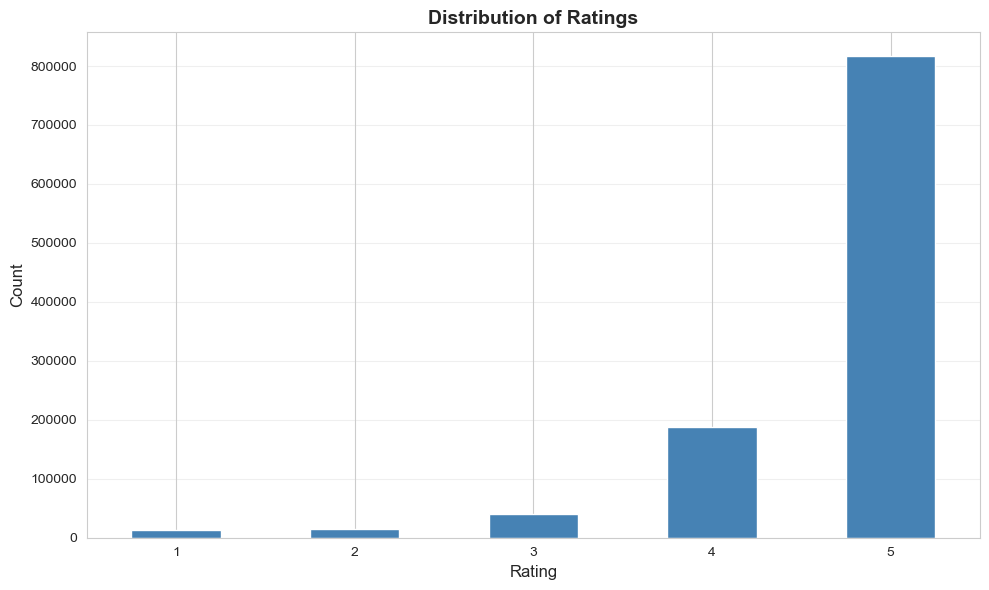

Mean rating: 4.66
Median rating: 5


In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
interactions_clean['rating'].value_counts().sort_index().plot(kind='bar', ax=ax, color='steelblue')
ax.set_xlabel('Rating', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Ratings', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../figures/fig 1 - rating_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Mean rating: {interactions_clean['rating'].mean():.2f}")
print(f"Median rating: {interactions_clean['rating'].median():.0f}")

Figure 1 – Distribution of Ratings

What it shows: A bar chart of how many reviews gave each star rating (1–5).

What it says: The bars for 4 and 5 are much taller, so ratings are heavily skewed high, most users give positive ratings, and low ratings (1–2) are rare. The printed mean/median confirm this (mean ≈ 4+, median = 5).

Why it matters: It tells you that “like vs not like” is very imbalanced and that almost everything looks good on average, which you need to remember when building a classifier for RQ1.

### Calories distribution

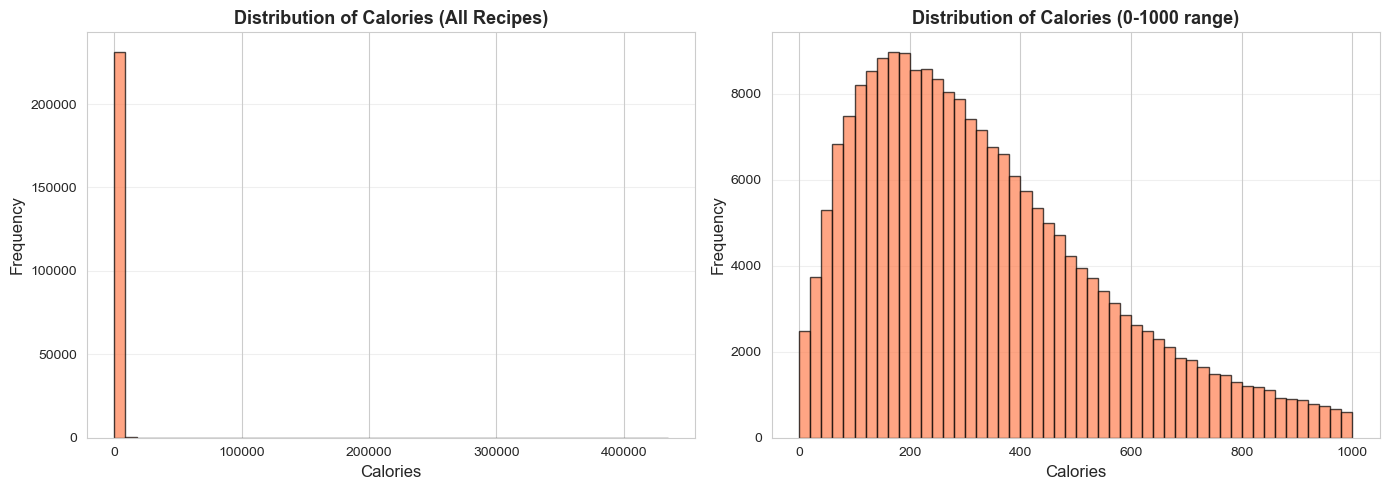

Calories - Mean: 473.9, Median: 313.4


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full distribution
axes[0].hist(recipes_clean['calories'].dropna(), bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Calories', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Calories (All Recipes)', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')

# Zoomed in (reasonable range)
calories_filtered = recipes_clean['calories'][(recipes_clean['calories'] > 0) & (recipes_clean['calories'] < 1000)]
axes[1].hist(calories_filtered, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Calories', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Calories (0-1000 range)', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../figures/fig 2 - calories_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Calories - Mean: {recipes_clean['calories'].mean():.1f}, Median: {recipes_clean['calories'].median():.1f}")

Figure 2 – Distribution of Calories

What it shows:
- Left panel: histogram of calories for all recipes.
- Right panel: the same but zoomed into 0–1000 calories to ignore extreme outliers.

What it says:
- The full plot shows a long right tail—some recipes have very high calories.
- The zoomed plot shows most recipes clustered in a moderate calorie range, and you see the mean and median calories printed below.

Why it matters: This motivates capping and log-transforming minutes/calories and helps define what “low-calorie” or “healthy” means for RQ2 and RQ3.


### Join data for analysis

In [21]:
df_joined = interactions_clean.merge(recipes_clean, left_on='recipe_id', right_on='id', how='inner')
print(f"Joined dataset size: {len(df_joined)} rows")

Joined dataset size: 1071520 rows


### Healthy vs Unhealthy Ratings

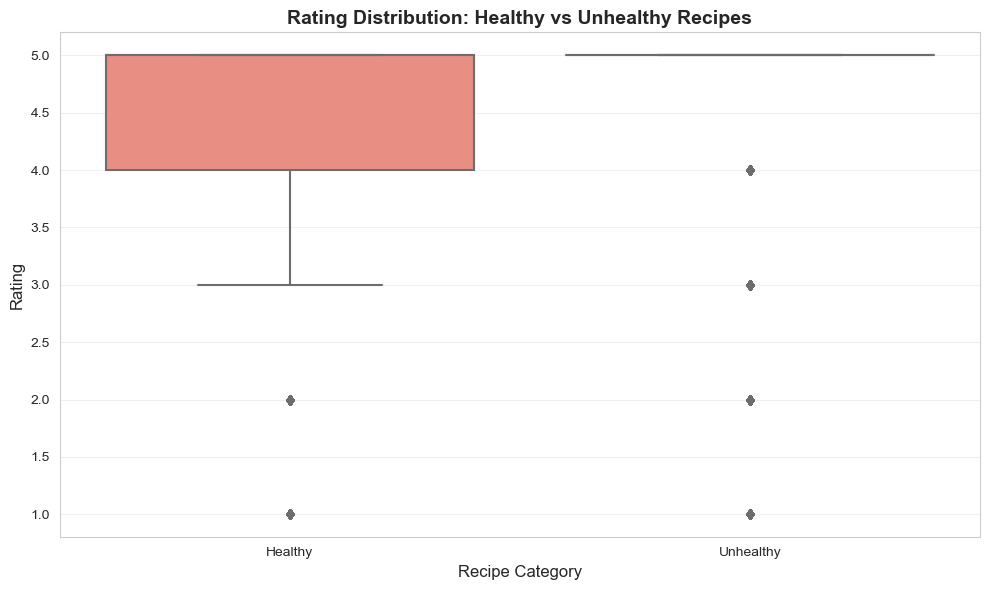


Mean ratings by health category:
                mean  median   count
is_healthy                          
0           4.667128     5.0  719577
1           4.649989     5.0  351943


In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

df_plot = df_joined[['is_healthy', 'rating']].copy()
df_plot['health_label'] = df_plot['is_healthy'].map({0: 'Unhealthy', 1: 'Healthy'})

sns.boxplot(data=df_plot, x='health_label', y='rating', palette=['salmon', 'lightgreen'], ax=ax)
ax.set_xlabel('Recipe Category', fontsize=12)
ax.set_ylabel('Rating', fontsize=12)
ax.set_title('Rating Distribution: Healthy vs Unhealthy Recipes', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../figures/fig 3 - healthy_vs_unhealthy_ratings.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistics
print("\nMean ratings by health category:")
print(df_joined.groupby('is_healthy')['rating'].agg(['mean', 'median', 'count']))

Figure 3 – Ratings: Healthy vs Unhealthy Recipes

What it shows: A boxplot comparing rating distributions for “Healthy” vs “Unhealthy” recipes (where “healthy” is defined using the calorie/sugar/saturated fat thresholds).

What it says: We can directly see if healthy recipes get similar, higher, or lower ratings than unhealthy ones (compare medians, IQR, and outliers between the two boxes). The printed group stats (mean, median, count) quantify that difference.

Why it matters: This is the main first look for RQ2: Are healthier recipes systematically rated lower?

### Calories vs Rating scatter plot

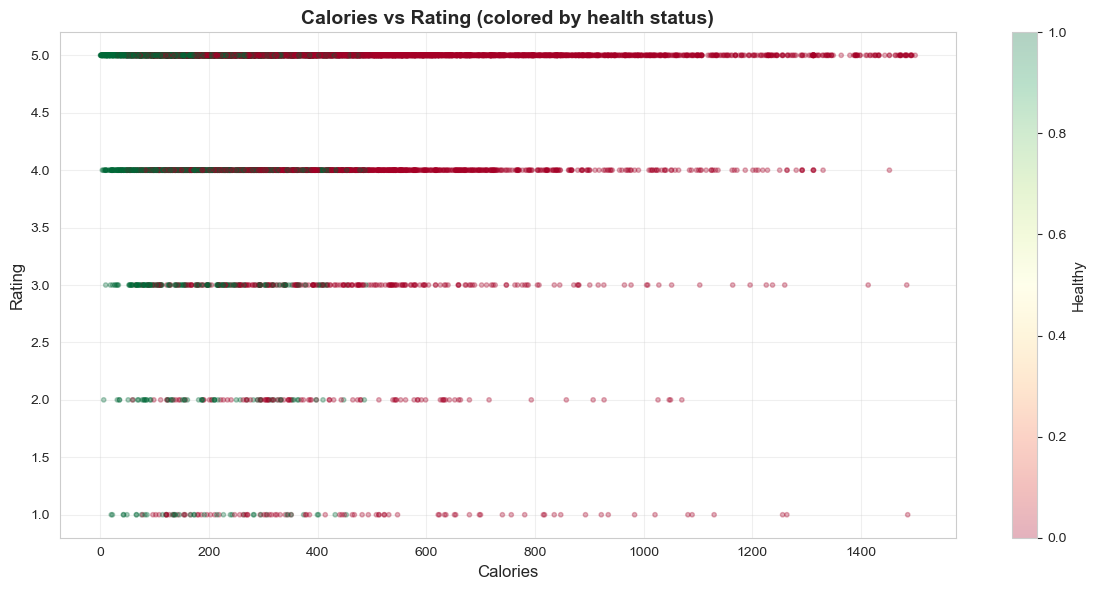

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))

# Sample for visualization (too many points otherwise)
df_sample = df_joined[df_joined['calories'] < 1500].sample(n=min(10000, len(df_joined)), random_state=42)

scatter = ax.scatter(df_sample['calories'], df_sample['rating'], 
                    c=df_sample['is_healthy'], cmap='RdYlGn', 
                    alpha=0.3, s=10)
ax.set_xlabel('Calories', fontsize=12)
ax.set_ylabel('Rating', fontsize=12)
ax.set_title('Calories vs Rating (colored by health status)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Healthy', fontsize=11)

plt.tight_layout()
plt.savefig('../figures/fig 4 - rating_vs_calories_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

Figure 4 – Calories vs Rating (Scatter, Colored by Health)

What it shows:
- x-axis: calories
- y-axis: rating
- each dot = a (recipe, rating) pair, sampled from recipes with calories < 1500
- color = health status (is_healthy, using a red–green colormap)

What it says:
- See whether higher-calorie recipes tend to get higher or lower ratings.
- The color overlay show if healthy (greenish) vs unhealthy (reddish) recipes cluster differently in the rating space.

Why it matters: It gives a visual, continuous view of the health–rating relationship beyond just “healthy vs not” groups.

### Correlation heatmap of nutrition features

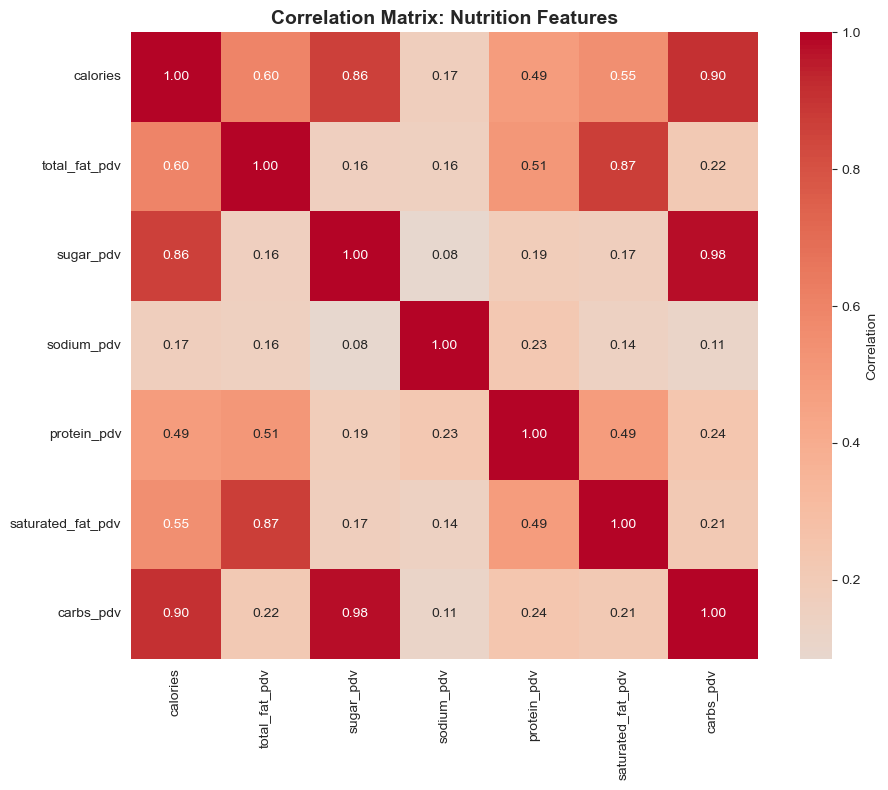

In [24]:
nutrition_cols = ['calories', 'total_fat_pdv', 'sugar_pdv', 'sodium_pdv', 
                 'protein_pdv', 'saturated_fat_pdv', 'carbs_pdv']

fig, ax = plt.subplots(figsize=(10, 8))
corr_matrix = recipes_clean[nutrition_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
           center=0, square=True, ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Correlation Matrix: Nutrition Features', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../figures/fig 5 - nutrition_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

Figure 5 – Correlation Matrix of Nutrition Features

What it shows: A heatmap of the correlations between nutrition variables: calories, total_fat_pdv, sugar_pdv, sodium_pdv, protein_pdv, saturated_fat_pdv, carbs_pdv.

What it says:
- Warm colors (red) = strong positive correlation (they go up together).
- Cool colors (blue) = negative correlation.
- Show, for example, whether calories are closely tied to carbs or fat, or if some nutrients are mostly independent.

Why it matters:
- Tells you which nutrition features are redundant or strongly linked, which affects feature choice for modeling in RQ1.
- Helps interpret what “healthiness” actually looks like in the data.

### Rating by cooking time categories

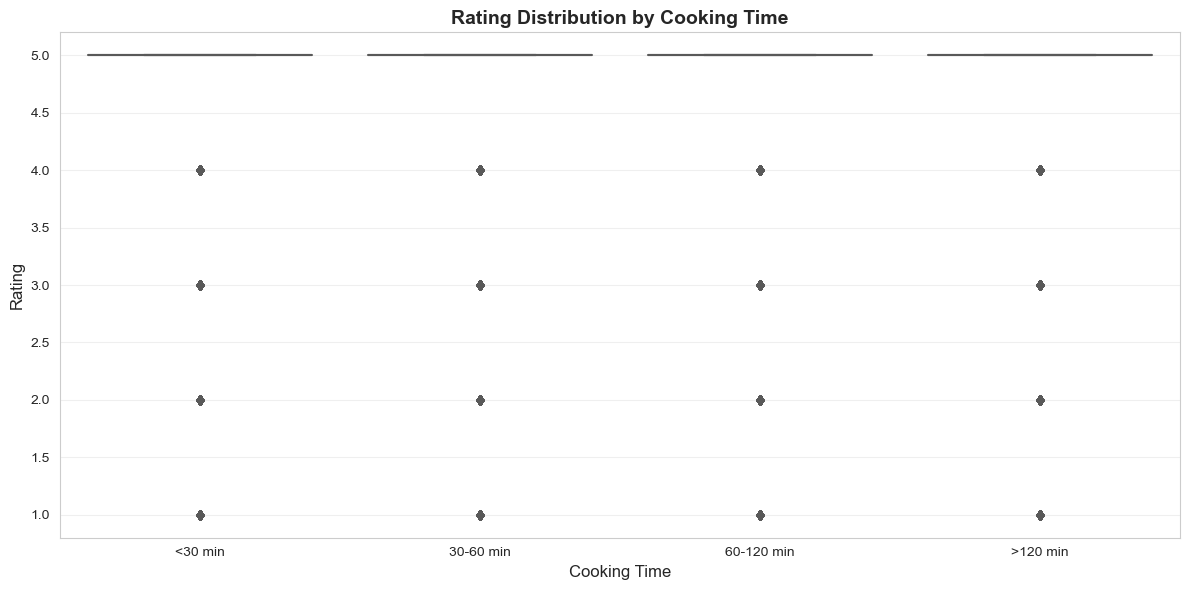

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))

# Categorize minutes
df_time = df_joined[df_joined['minutes'] < 300].copy()
df_time['time_category'] = pd.cut(df_time['minutes'], 
                                   bins=[0, 30, 60, 120, 300],
                                   labels=['<30 min', '30-60 min', '60-120 min', '>120 min'])

sns.boxplot(data=df_time, x='time_category', y='rating', palette='Set2', ax=ax)
ax.set_xlabel('Cooking Time', fontsize=12)
ax.set_ylabel('Rating', fontsize=12)
ax.set_title('Rating Distribution by Cooking Time', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../figures/fig 6 - rating_by_cooking_time.png', dpi=300, bbox_inches='tight')
plt.show()

Figure 6 – Ratings by Cooking Time Category

What it shows: A boxplot of ratings across four cooking time bins (<30 min, 30–60, 60–120, >120 minutes), using only recipes with minutes < 300.

What it says:
- Show if quick recipes (<30 min) get systematically higher or lower ratings than long, involved recipes (>120 min).
- Compare medians and spreads across the time categories.

Why it matters:
- Shows how convenience vs effort (cooking time) relates to user satisfaction.
- Also hints at useful predictors for RQ1 and potential confounders in RQ2 (maybe healthy recipes also tend to take longer or shorter).

## **Save Cleaned Data**

In [26]:
recipes_clean.to_csv('../datasets/recipes_clean.csv', index=False)
interactions_clean.to_csv('../datasets/interactions_clean.csv', index=False)

print("Cleaned data saved!")
print(f"- recipes_clean.csv: {len(recipes_clean)} rows")
print(f"- interactions_clean.csv: {len(interactions_clean)} rows")

Cleaned data saved!
- recipes_clean.csv: 231637 rows
- interactions_clean.csv: 1071520 rows


## 7. Key Findings Summary

**Data Overview:**
- Total recipes and interactions analyzed
- Rating distribution is heavily skewed toward high ratings (4-5 stars)
- Many recipes with zero ratings were removed

**Healthiness Analysis:**
- Only a small fraction of recipes meet our "healthy" criteria
- Healthy recipes appear to have slightly different rating distributions
- Calories and other nutrition factors show interesting correlations

**Next Steps:**
- Build predictive models for rating prediction
- Develop recommender system
- Analyze health bias in recommendations